# Importing necessary packages

## General packages

In [1]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Electra classifier

In [2]:
print("Preparing Electra Classifier...")
from electra_classifier import *

best_model_path = "electra_cls/lightning_logs/version_18/checkpoints/epoch=9-step=3629.ckpt"
emotion_categories = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral']

MODEL_NAME = "google/electra-base-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)

trained_model = EmotionClassifier.load_from_checkpoint(
    # trainer.checkpoint_callback.best_model_path,
    best_model_path,
    n_classes=len(emotion_categories)
)

def predict_emotion_and_probability(text):
    encoding = tokenizer(
          text,
          max_length=64, 
          truncation=True,
          padding="max_length",
          add_special_tokens=True,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors="pt"
      )
    outputs = trained_model(**encoding)
    probabilities = list(torch.softmax(outputs, dim=-1).detach().numpy().flatten())
    emotion_idx = torch.argmax(outputs, dim=-1).item() 
    predicted_emotion = emotion_categories[emotion_idx]

    emotion_categories_list = list(emotion_categories)
    probabilities, emotion_categories_list = zip(*sorted(zip(probabilities, emotion_categories_list)))
    probabilities = probabilities[::-1]
    emotion_categories_list = emotion_categories_list[::-1]
    emotion_probability = round(100*probabilities[0], 2)#:.2f

    return predicted_emotion, emotion_probability

print("Electra Classifier is ready!")

Preparing Electra Classifier...


Global seed set to 42
Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraClassifier: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraClassifier were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias'

Electra Classifier is ready!


In [3]:
sample_text = "I do! I was so happy when I opened the box and that fat mofo jumped out!"
predict_emotion_and_probability(sample_text)

('joy', 98.35)

# Importing data

## The first 10% of the data

In [4]:
chatept_output_10 = pd.read_pickle("ChatEPT/first_10_percent_grouped_by_df")
chatept_output_10 = chatept_output_10.drop('utterance_2_emotion', axis=1)
chatept_output_10.head()

conv_id      context  \
0          hit:0_conv:1  sentimental   
1  hit:10000_conv:20000    surprised   
2  hit:10000_conv:20001    impressed   
3  hit:10001_conv:20002       lonely   
4  hit:10002_conv:20004      ashamed   

                                           utterance  \
0  [I remember going to see the fireworks with my...   
1  [My girlfriend got me a pet toad today!, Do yo...   
2  [I really like the new paint job on my house.,...   
3  [I went to the skating rink all by myself toda...   
4  [I was walking on the road. I saw a beggar and...   

  utterance_minus_2_emotion  utterance_minus_2_emotion_conf  \
0                   neutral                           99.86   
1                       joy                           98.35   
2                   neutral                           91.12   
3            disappointment                           31.49   
4             embarrassment                           99.49   

                         chatgpt_response_no_emotion  \
0  I'm sorry to hear that. It's tough losing a go...   
1  That's great to hear! Toads can make wonderful...   
2  That sounds like a beautiful combination of co...   
3  I'm sorry to hear that. It's tough to feel lef...   
4  It's never too late to help someone in need. N...   

                          chatgpt_emotional_response  
0  (neutral, 99.86, I'm sorry to hear that. Losin...  
1  (joy, 98.35, That's great to hear! Toads can m...  
2  (neutral, 91.12, Blue and yellow is a lovely c...  
3  (disappointment, 31.49, I'm sorry to hear that...  
4  (embarrassment, 99.49, That's completely under...

## The last 90% of the data

In [5]:
chatept_output_90 = pd.read_pickle("ChatEPT/merged_last_90_percent_all_df")
chatept_output_90 = chatept_output_90.drop('utterance_2_emotion', axis=1)
chatept_output_90.head()

conv_id       context  \
0  hit:11426_conv:22853     disgusted   
1  hit:11427_conv:22854  apprehensive   
2  hit:11427_conv:22855       furious   
3  hit:11428_conv:22856   embarrassed   
4  hit:11428_conv:22857     confident   

                                           utterance  \
0  [I went into my shed to clean it and i found a...   
1  [My sister asked me to go out for drinks with ...   
2  [I missed my train yesterday. I was so mad at ...   
3  [Yesterday When I was coming from my office. I...   
4  [I recently was in a Arcade game tournament. ,...   

  utterance_minus_2_emotion  utterance_minus_2_emotion_conf  \
0                   neutral                           99.85   
1                 annoyance                           94.36   
2            disappointment                           71.76   
3                 amusement                           92.57   
4                  approval                           27.76   

                          chatgpt_emotional_response  \
0  (neutral, 99.85, That was responsible of you t...   
1  (annoyance, 94.36, That's fine. It's important...   
2  (disappointment, 71.76, That's understandable....   
3  (amusement, 92.57, I'm sorry to hear that. It ...   
4  (approval, 27.76, That's awesome! Second place...   

                         chatgpt_response_no_emotion  
0  That was a responsible way to handle the situa...  
1  That's okay, you have the right to decline. Yo...  
2  That's frustrating. Hopefully, you were able t...  
3  I'm sorry to hear that. It can be embarrassing...  
4  That's still impressive! Congrats on your achi...

## Merging the two parts

In [6]:
chatept_output = pd.concat([chatept_output_10, chatept_output_90])
chatept_output = chatept_output.reset_index()
chatept_output.head()

index               conv_id      context  \
0      0          hit:0_conv:1  sentimental   
1      1  hit:10000_conv:20000    surprised   
2      2  hit:10000_conv:20001    impressed   
3      3  hit:10001_conv:20002       lonely   
4      4  hit:10002_conv:20004      ashamed   

                                           utterance  \
0  [I remember going to see the fireworks with my...   
1  [My girlfriend got me a pet toad today!, Do yo...   
2  [I really like the new paint job on my house.,...   
3  [I went to the skating rink all by myself toda...   
4  [I was walking on the road. I saw a beggar and...   

  utterance_minus_2_emotion  utterance_minus_2_emotion_conf  \
0                   neutral                           99.86   
1                       joy                           98.35   
2                   neutral                           91.12   
3            disappointment                           31.49   
4             embarrassment                           99.49   

                         chatgpt_response_no_emotion  \
0  I'm sorry to hear that. It's tough losing a go...   
1  That's great to hear! Toads can make wonderful...   
2  That sounds like a beautiful combination of co...   
3  I'm sorry to hear that. It's tough to feel lef...   
4  It's never too late to help someone in need. N...   

                          chatgpt_emotional_response  
0  (neutral, 99.86, I'm sorry to hear that. Losin...  
1  (joy, 98.35, That's great to hear! Toads can m...  
2  (neutral, 91.12, Blue and yellow is a lovely c...  
3  (disappointment, 31.49, I'm sorry to hear that...  
4  (embarrassment, 99.49, That's completely under...

In [7]:
chatept_output[chatept_output.index.duplicated()]

Empty DataFrame
Columns: [index, conv_id, context, utterance, utterance_minus_2_emotion, utterance_minus_2_emotion_conf, chatgpt_response_no_emotion, chatgpt_emotional_response]
Index: []

# Labelling chatept_output with electra emotions

## Non emotional version

In [8]:
chatept_output["no_emotion_chatgpt_response_emotion"] = chatept_output.chatgpt_response_no_emotion.progress_apply(lambda x: predict_emotion_and_probability(x))

  0%|          | 0/17780 [00:00<?, ?it/s]

In [9]:
chatept_output.head()

index               conv_id      context  \
0      0          hit:0_conv:1  sentimental   
1      1  hit:10000_conv:20000    surprised   
2      2  hit:10000_conv:20001    impressed   
3      3  hit:10001_conv:20002       lonely   
4      4  hit:10002_conv:20004      ashamed   

                                           utterance  \
0  [I remember going to see the fireworks with my...   
1  [My girlfriend got me a pet toad today!, Do yo...   
2  [I really like the new paint job on my house.,...   
3  [I went to the skating rink all by myself toda...   
4  [I was walking on the road. I saw a beggar and...   

  utterance_minus_2_emotion  utterance_minus_2_emotion_conf  \
0                   neutral                           99.86   
1                       joy                           98.35   
2                   neutral                           91.12   
3            disappointment                           31.49   
4             embarrassment                           99.49   

                         chatgpt_response_no_emotion  \
0  I'm sorry to hear that. It's tough losing a go...   
1  That's great to hear! Toads can make wonderful...   
2  That sounds like a beautiful combination of co...   
3  I'm sorry to hear that. It's tough to feel lef...   
4  It's never too late to help someone in need. N...   

                          chatgpt_emotional_response  \
0  (neutral, 99.86, I'm sorry to hear that. Losin...   
1  (joy, 98.35, That's great to hear! Toads can m...   
2  (neutral, 91.12, Blue and yellow is a lovely c...   
3  (disappointment, 31.49, I'm sorry to hear that...   
4  (embarrassment, 99.49, That's completely under...   

  no_emotion_chatgpt_response_emotion  
0                      (grief, 55.02)  
1                 (admiration, 90.69)  
2                 (admiration, 90.89)  
3                    (remorse, 82.51)  
4                     (caring, 94.53)

## Emotional version

In [10]:
chatept_output["emotional_chatgpt_response_emotion"] = chatept_output.chatgpt_emotional_response.progress_apply(lambda x: predict_emotion_and_probability(x[2]))

  0%|          | 0/17780 [00:00<?, ?it/s]

In [11]:
chatept_output.head()

index               conv_id      context  \
0      0          hit:0_conv:1  sentimental   
1      1  hit:10000_conv:20000    surprised   
2      2  hit:10000_conv:20001    impressed   
3      3  hit:10001_conv:20002       lonely   
4      4  hit:10002_conv:20004      ashamed   

                                           utterance  \
0  [I remember going to see the fireworks with my...   
1  [My girlfriend got me a pet toad today!, Do yo...   
2  [I really like the new paint job on my house.,...   
3  [I went to the skating rink all by myself toda...   
4  [I was walking on the road. I saw a beggar and...   

  utterance_minus_2_emotion  utterance_minus_2_emotion_conf  \
0                   neutral                           99.86   
1                       joy                           98.35   
2                   neutral                           91.12   
3            disappointment                           31.49   
4             embarrassment                           99.49   

                         chatgpt_response_no_emotion  \
0  I'm sorry to hear that. It's tough losing a go...   
1  That's great to hear! Toads can make wonderful...   
2  That sounds like a beautiful combination of co...   
3  I'm sorry to hear that. It's tough to feel lef...   
4  It's never too late to help someone in need. N...   

                          chatgpt_emotional_response  \
0  (neutral, 99.86, I'm sorry to hear that. Losin...   
1  (joy, 98.35, That's great to hear! Toads can m...   
2  (neutral, 91.12, Blue and yellow is a lovely c...   
3  (disappointment, 31.49, I'm sorry to hear that...   
4  (embarrassment, 99.49, That's completely under...   

  no_emotion_chatgpt_response_emotion emotional_chatgpt_response_emotion  
0                      (grief, 55.02)                   (sadness, 97.31)  
1                 (admiration, 90.69)                (admiration, 85.92)  
2                 (admiration, 90.89)                      (love, 94.29)  
3                    (remorse, 82.51)                  (optimism, 70.82)  
4                     (caring, 94.53)                  (approval, 57.74)

# Saving (or loading) chateptoutput labelled with electra

In [4]:
#chatept_output.to_pickle("ChatEPT/chatept_output")
chatept_output = pd.read_pickle("ChatEPT/chatept_output")

## Verifying a sample

In [5]:
import random
i = random.randint(0, len(chatept_output))
row = chatept_output.iloc[i]
conversation = row.utterance
last_user_emotion = row.utterance_minus_2_emotion
chatgpt_completion = row.chatgpt_response_no_emotion
chatgpt_emotion = row.no_emotion_chatgpt_response_emotion
chatept_completion = row.chatgpt_emotional_response[2]
chatept_emotion = row.emotional_chatgpt_response_emotion
print("row number: ", i, "\n")
print("## The original conversation ##")
for utt in conversation:
    print("  - ", utt)
print(f"\n ## The user appears to feel ## \n  {last_user_emotion}.", "\n")
print("## ChatGPT completion ##\n", chatgpt_completion, "\n")
print("## ChatGPT emotion ##\n", chatgpt_emotion, "\n")
print("## ChatEPT completion ##\n", chatept_completion, "\n")
print("## ChatEPT emotion ##\n", chatept_emotion)

row number:  3648 

## The original conversation ##
  -  I really care about my brothers_comma_ our bond is closer than most I feel like
  -  thats what the love and family bond i think
  -  Yeah_comma_ it is very special to a lot of people_comma_ blood is thicker than water
  -  accepting .. but not in my case.. you are lucky i guess

 ## The user appears to feel ## 
  neutral. 

## ChatGPT completion ##
 That's true. Family bond is a precious thing and it's great that you share a strong connection with your brothers. 

## ChatGPT emotion ##
 ('admiration', 98.4) 

## ChatEPT completion ##
 Yes, family bonds are indeed very special and unique, and they have the ability to bring people closer together as nothing else can. 

## ChatEPT emotion ##
 ('admiration', 91.43)


In [6]:
sample_text = "Yes, family bonds are indeed very special and unique, and they have the ability to bring people closer together as nothing else can."
predict_emotion_and_probability(sample_text)

('admiration', 91.43)

In [10]:
chatept_output = pd.read_pickle("ChatEPT/chatept_output")

# Applying a mask to improve results:

In [8]:
initial_len = len(chatept_output)
#chatept_output = chatept_output[chatept_output.no_emotion_chatgpt_response_emotion.apply(lambda x: x[0]) == "neutral"]
new_len = len(chatept_output)
print(f"The number of conversations is reduced from {initial_len} to {new_len}.")
chatept_output.head()

The number of conversations is reduced from 17780 to 17780.


index               conv_id      context  \
0      0          hit:0_conv:1  sentimental   
1      1  hit:10000_conv:20000    surprised   
2      2  hit:10000_conv:20001    impressed   
3      3  hit:10001_conv:20002       lonely   
4      4  hit:10002_conv:20004      ashamed   

                                           utterance  \
0  [I remember going to see the fireworks with my...   
1  [My girlfriend got me a pet toad today!, Do yo...   
2  [I really like the new paint job on my house.,...   
3  [I went to the skating rink all by myself toda...   
4  [I was walking on the road. I saw a beggar and...   

  utterance_minus_2_emotion  utterance_minus_2_emotion_conf  \
0                   neutral                           99.86   
1                       joy                           98.35   
2                   neutral                           91.12   
3            disappointment                           31.49   
4             embarrassment                           99.49   

                         chatgpt_response_no_emotion  \
0  I'm sorry to hear that. It's tough losing a go...   
1  That's great to hear! Toads can make wonderful...   
2  That sounds like a beautiful combination of co...   
3  I'm sorry to hear that. It's tough to feel lef...   
4  It's never too late to help someone in need. N...   

                          chatgpt_emotional_response  \
0  (neutral, 99.86, I'm sorry to hear that. Losin...   
1  (joy, 98.35, That's great to hear! Toads can m...   
2  (neutral, 91.12, Blue and yellow is a lovely c...   
3  (disappointment, 31.49, I'm sorry to hear that...   
4  (embarrassment, 99.49, That's completely under...   

  no_emotion_chatgpt_response_emotion emotional_chatgpt_response_emotion  
0                      (grief, 55.02)                   (sadness, 97.31)  
1                 (admiration, 90.69)                (admiration, 85.92)  
2                 (admiration, 90.89)                      (love, 94.29)  
3                    (remorse, 82.51)                  (optimism, 70.82)  
4                     (caring, 94.53)                  (approval, 57.74)

# Data wrangling

In [11]:
outputs_df = chatept_output[["conv_id", "utterance_minus_2_emotion", "no_emotion_chatgpt_response_emotion", "emotional_chatgpt_response_emotion"]]
outputs_df = outputs_df.rename(columns={"conv_id": "conv_id", 'no_emotion_chatgpt_response_emotion': 'non_emotional', 'emotional_chatgpt_response_emotion': 'emotional'})

outputs_df[['non_emotional_emotion', 'non_emotional_conf']] = outputs_df['non_emotional'].apply(lambda x: pd.Series(x))
outputs_df = outputs_df.drop('non_emotional', axis=1)

outputs_df[['emotional_emotion', 'emotional_conf']] = outputs_df['emotional'].apply(lambda x: pd.Series(x))
outputs_df = outputs_df.drop('emotional', axis=1)

outputs_df.head()

conv_id utterance_minus_2_emotion non_emotional_emotion  \
0          hit:0_conv:1                   neutral                 grief   
1  hit:10000_conv:20000                       joy            admiration   
2  hit:10000_conv:20001                   neutral            admiration   
3  hit:10001_conv:20002            disappointment               remorse   
4  hit:10002_conv:20004             embarrassment                caring   

   non_emotional_conf emotional_emotion  emotional_conf  
0               55.02           sadness           97.31  
1               90.69        admiration           85.92  
2               90.89              love           94.29  
3               82.51          optimism           70.82  
4               94.53          approval           57.74

In [12]:
#outputs_df.to_pickle("ChatEPT/outputs_df")
#outputs_df = pd.read_pickle("ChatEPT/outputs_df")

# Analyzing the results

## Which conversations kept the same emotion labels?

In [13]:
agreements_df = outputs_df[outputs_df.non_emotional_emotion == outputs_df.emotional_emotion]
agreements = len(agreements_df)
print(f"So {round(100*agreements/len(outputs_df))}% of the responses kept the same emotion label.\nHow about the emotion intensity?")

So 45% of the responses kept the same emotion label.
How about the emotion intensity?


In [14]:
changes_per_emotion_category = []
supports = []
for i in range(len(emotion_categories)):
    emotion_i = emotion_categories[i]
    df_of_emotion_i = agreements_df[agreements_df.non_emotional_emotion == emotion_i]
    mean_non_emotional = df_of_emotion_i.non_emotional_conf.mean()
    mean_emotional = df_of_emotion_i.emotional_conf.mean()
    change = mean_non_emotional - mean_emotional
    changes_per_emotion_category.append(change)
    support = len(df_of_emotion_i)
    supports.append(support)
    #print(f"{emotion_i.upper()} was changed by {np.floor(change)}% with a support of {len(df_of_emotion_i)}.")
sum_mean = np.nansum(np.array(changes_per_emotion_category))
avg_mean = np.nanmean(np.array(changes_per_emotion_category))
#changes_df = pd.Dataframe({"Emotion": emotion_categories, "ChatGPT_intensity})
print(f"On average, the prompts increased emotional intensity by {int(avg_mean)}% or sum: {int(sum_mean)}%.")

On average, the prompts increased emotional intensity by 0% or sum: -24%.


In [ ]:
emotion_dict = {}

for key in emotion_categories:
    value = input("Enter a value for key '{}': ".format(key))
    emotion_dict[key] = value

print(emotion_dict)


NameError: name 'emotion_dict' is not defined

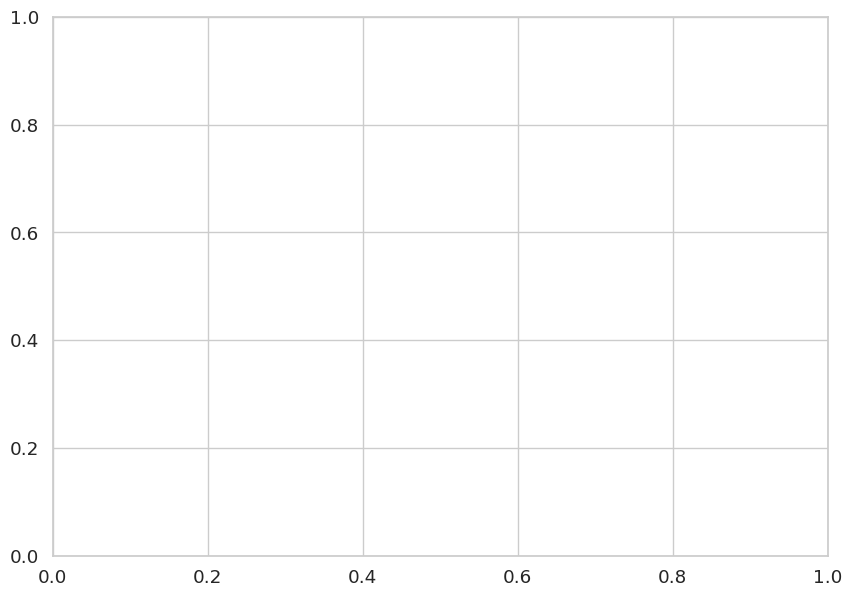

In [15]:
# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,7))

# Sort the data by emotion intensity
sorted_changes_per_emotion_category, sorted_emotion_categories = zip(*sorted(zip(changes_per_emotion_category, emotion_categories)))

emotion_colors_dict = {"positive": "green", "negative": "red", "ambiguous": "orange", "neutral": "gray"}
emotion_colors = [emotion_colors_dict[emotion_label] for emotion_label in [emotion_dict[emotion] for emotion in sorted_emotion_categories]]

#ax.barh(sorted_emotion_categories, sorted_changes_per_emotion_category, color='b')
ax.barh(sorted_emotion_categories, sorted_changes_per_emotion_category, color=emotion_colors)
#ax.tick_params(axis='y', colors=[colors[key] for key in data.keys()])
#ax.barh(emotion_categories, changes_per_emotion_category, color='b')

# Set chart title and axis labels
ax.set_title('Emotion intensity change per emotion label', fontsize=18)
ax.set_xlabel('Percentage', fontsize=14)
ax.set_ylabel('Emotion', fontsize=14)

# Show the chart
plt.show()

In [124]:
positive_indexes = [i for i in range(len(emotion_categories)) if emotion_dict[emotion_categories[i]]=="positive"]
positive_emotion_changes = [changes_per_emotion_category[i] for i in positive_indexes]

negative_indexes = [i for i in range(len(emotion_categories)) if emotion_dict[emotion_categories[i]]=="negative"]
negative_emotion_changes = [changes_per_emotion_category[i] for i in negative_indexes]

amb_indexes = [i for i in range(len(emotion_categories)) if emotion_dict[emotion_categories[i]]=="ambiguous"]
ambiguous_emotion_changes = [changes_per_emotion_category[i] for i in amb_indexes]

print(f"Positive emotion categories changed by +{int(np.nanmean(positive_emotion_changes))}%.")
print(f"Negative emotion categories increased by {int(np.nanmean(negative_emotion_changes))}%.")
print(f"Ambiguous emotion categories increased by {int(np.nanmean(ambiguous_emotion_changes))}%.")

Positive emotion categories changed by +2%.
Negative emotion categories increased by -2%.
Ambiguous emotion categories increased by -7%.


## What about the labels that changed?

### Overall emotion changes

In [152]:
changes_per_emotion = []
changes_per_emotion_normalized = []
for emotion in emotion_categories:
    value_counts_emotional = outputs_df.emotional_emotion.value_counts()
    value_counts_non_emotional = outputs_df.non_emotional_emotion.value_counts()
    
    if emotion in value_counts_emotional:
        count_emotional = value_counts_emotional[emotion]
    else:
        count_emotional = 0
            
    if emotion in value_counts_non_emotional:
        count_non_emotional = value_counts_non_emotional[emotion]
    else: 
        count_non_emotional = 0
        
    changes_per_emotion.append(count_emotional - count_non_emotional)
    if count_emotional + count_non_emotional != 0:
        changes_per_emotion_normalized.append(100*(count_emotional - count_non_emotional)/(count_emotional + count_non_emotional))

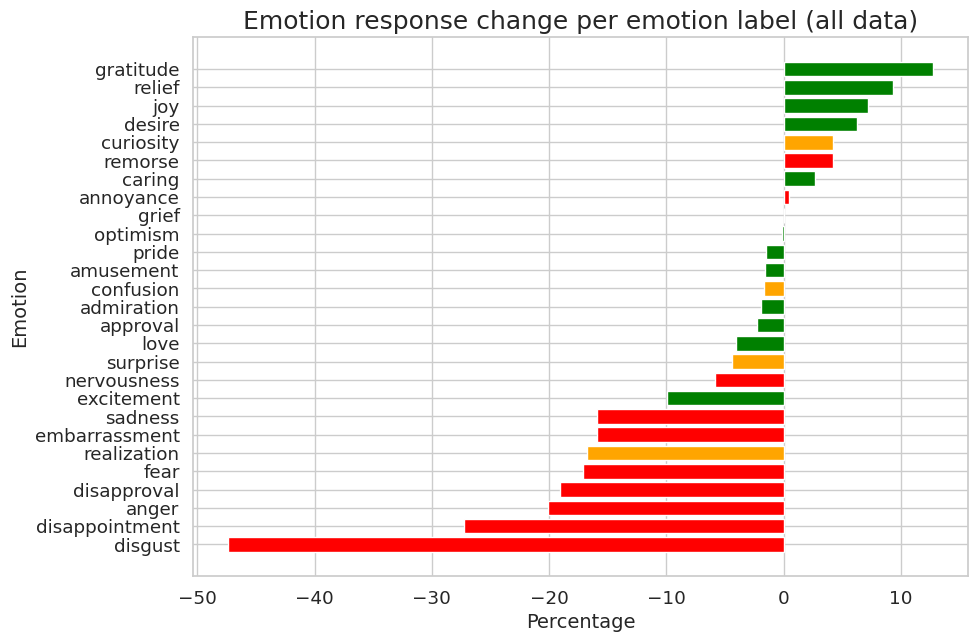

In [155]:
# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,7))

# Sort the data by emotion intensity
sorted_changes_per_emotion_category, sorted_emotion_categories = zip(*sorted(zip(changes_per_emotion_normalized, emotion_categories)))

emotion_colors_dict = {"positive": "green", "negative": "red", "ambiguous": "orange", "neutral": "gray"}
emotion_colors = [emotion_colors_dict[emotion_label] for emotion_label in [emotion_dict[emotion] for emotion in sorted_emotion_categories]]

#ax.barh(sorted_emotion_categories, sorted_changes_per_emotion_category, color='b')
ax.barh(sorted_emotion_categories, sorted_changes_per_emotion_category, color=emotion_colors)
#ax.tick_params(axis='y', colors=[colors[key] for key in data.keys()])
#ax.barh(emotion_categories, changes_per_emotion_category, color='b')

# Set chart title and axis labels
ax.set_title('Emotion response change per emotion label (all data)', fontsize=18)
ax.set_xlabel('Percentage', fontsize=14)
ax.set_ylabel('Emotion', fontsize=14)

# Show the chart
plt.show()

### What user emotions changed the chatbot emotion?

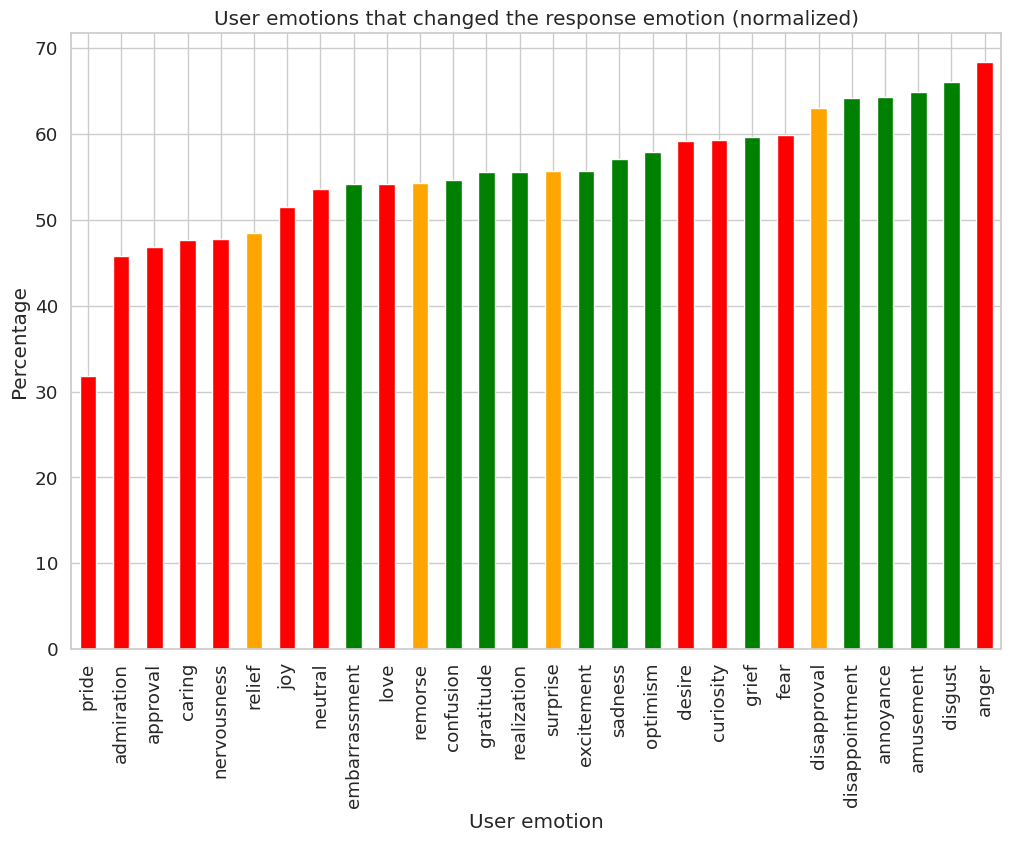

In [167]:
mask = chatept_output['no_emotion_chatgpt_response_emotion'].apply(lambda x: x[0]) != chatept_output['emotional_chatgpt_response_emotion'].apply(lambda x: x[0])
value_counts = chatept_output[mask].utterance_minus_2_emotion.value_counts()
# Normalizing to the number of occurences of each emotion
for emotion in value_counts.index:
    value_counts.loc[emotion] = 100*value_counts.loc[emotion]/chatept_output.utterance_minus_2_emotion.value_counts().loc[emotion]

#value_counts/chatept_output.utterance_minus_2_emotion.value_counts()

# Plot the histogram
fig, ax = plt.subplots()
#value_counts.plot(kind='bar', ax=ax)
sorted_value_counts = value_counts.sort_values(ascending=True)
sorted_colors = [emotion_colors_dict[emotion_dict[emotion]] for emotion in sorted_value_counts.index]
#value_counts.plot(kind='bar', ax=ax)
sorted_value_counts.plot(kind='bar', ax=ax, color=emotion_colors)

# Customize the plot
ax.set_xlabel('User emotion')
ax.set_ylabel('Percentage')
ax.set_title("User emotions that changed the response emotion (normalized)")

# Display the plot
plt.show()

### Which ChatGPT emotions were changed with the introduction of the user emotion?

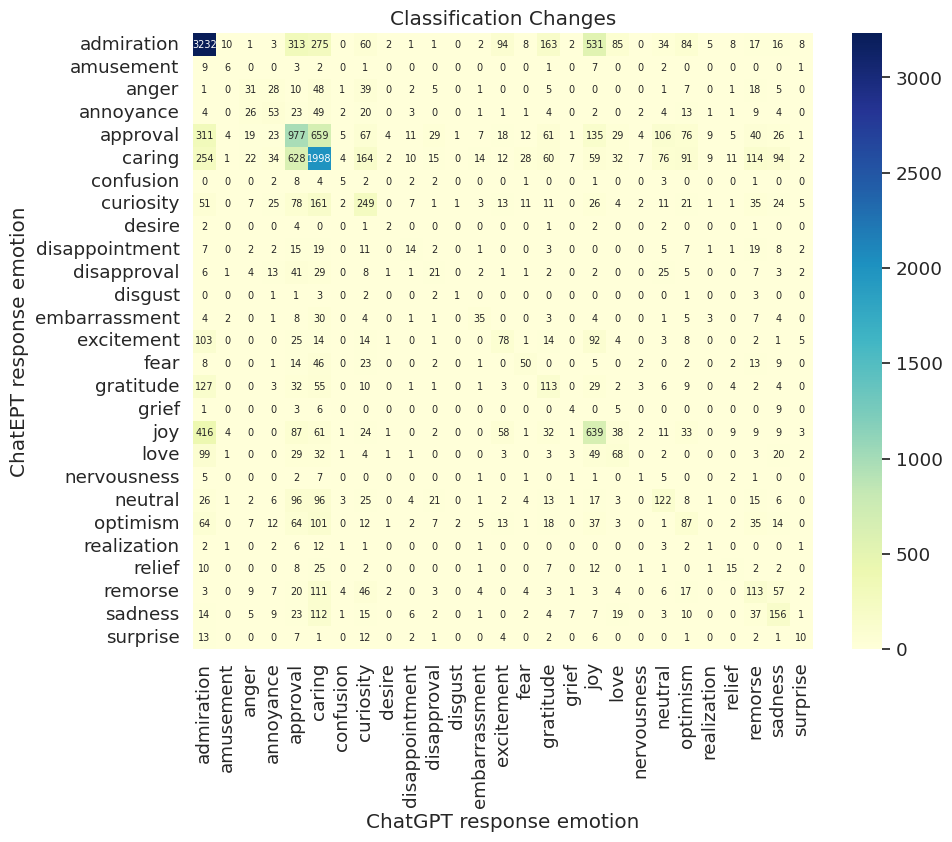

In [126]:
# Create two sample Series
s1 = outputs_df.non_emotional_emotion
s2 = outputs_df.emotional_emotion

# Create a crosstab of the two Series
crosstab = pd.crosstab(s1, s2)

# Create a heatmap of the crosstab
plt.figure(figsize=(10,8))
sns.heatmap(crosstab, annot=True, cmap='YlGnBu', fmt='.0f', annot_kws={'fontsize':7})

plt.xlabel('ChatGPT response emotion')
plt.ylabel('ChatEPT response emotion')
plt.title('Classification Changes')
plt.show()

<Figure size 800x600 with 0 Axes>

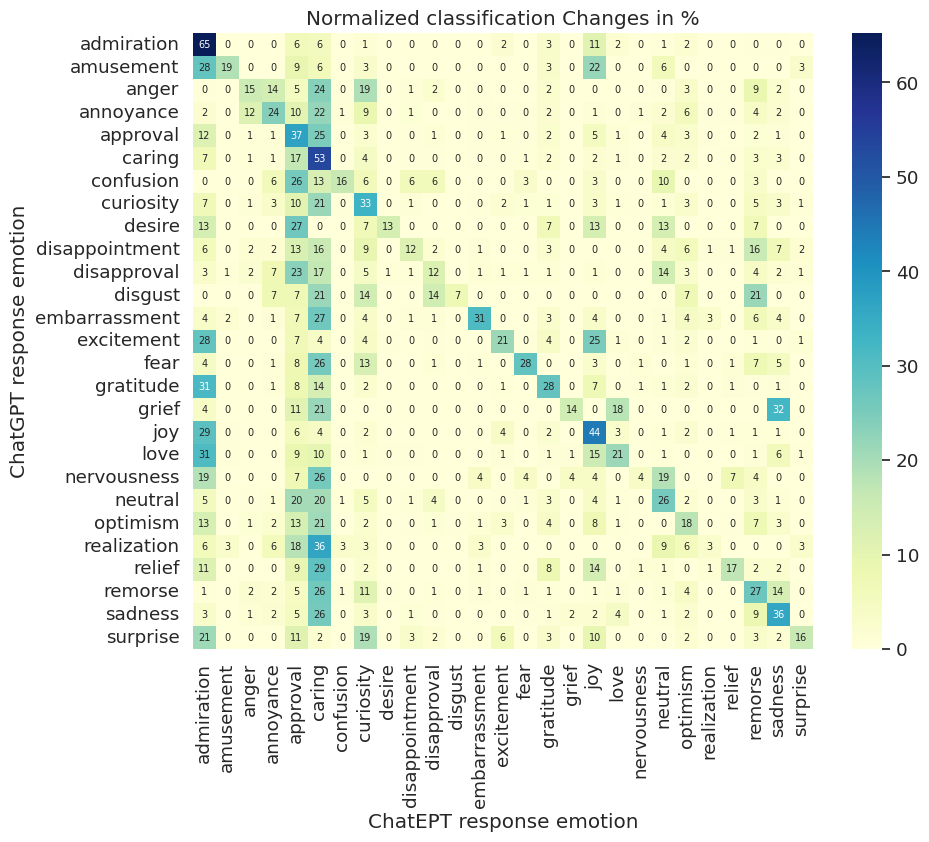

In [15]:
# Create two sample Series
s1 = outputs_df.non_emotional_emotion
s2 = outputs_df.emotional_emotion

# Create a crosstab of the two Series
crosstab = pd.crosstab(s1, s2)

plt.figure(figsize=(8,6))

# define a normalization function
def normalize_row(row):
    return row / row.sum()

# apply the normalization function to each row of the crosstab
crosstab_norm = 100*crosstab.apply(normalize_row, axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab_norm, annot=True, cmap='YlGnBu', fmt='.0f', annot_kws={'fontsize':7})

plt.xlabel('ChatEPT response emotion')
plt.ylabel('ChatGPT response emotion')
plt.title('Normalized classification Changes in %')
plt.show()

### What emotion did ChatGPT choose per detected user emotion?

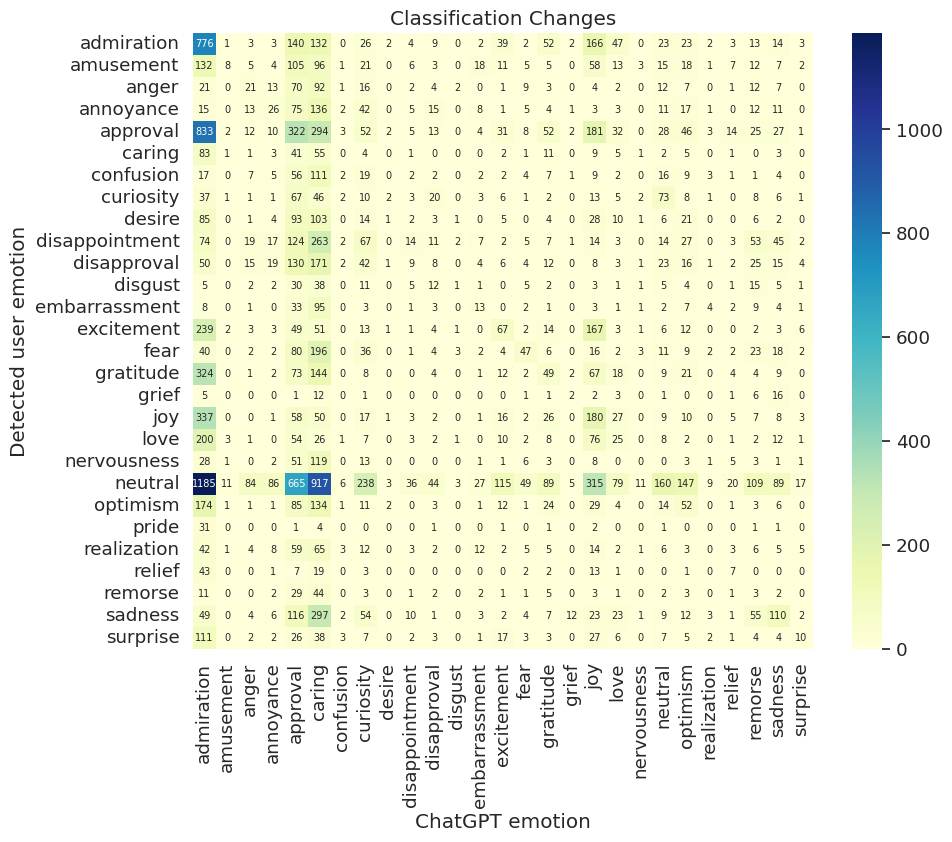

In [16]:
# Create two sample Series
s1 = chatept_output.utterance_minus_2_emotion
s2 = outputs_df.non_emotional_emotion

# Create a crosstab of the two Series
crosstab_non_emotional = pd.crosstab(s1, s2)

# Create a heatmap of the crosstab
plt.figure(figsize=(10,8))
sns.heatmap(crosstab_non_emotional, annot=True, cmap='YlGnBu', fmt='.0f', annot_kws={'fontsize':7})
plt.xlabel('ChatGPT emotion')
plt.ylabel('Detected user emotion')
plt.title('Classification Changes')
plt.show()

### What emotion did ChatEPT choose per detected user emotion?

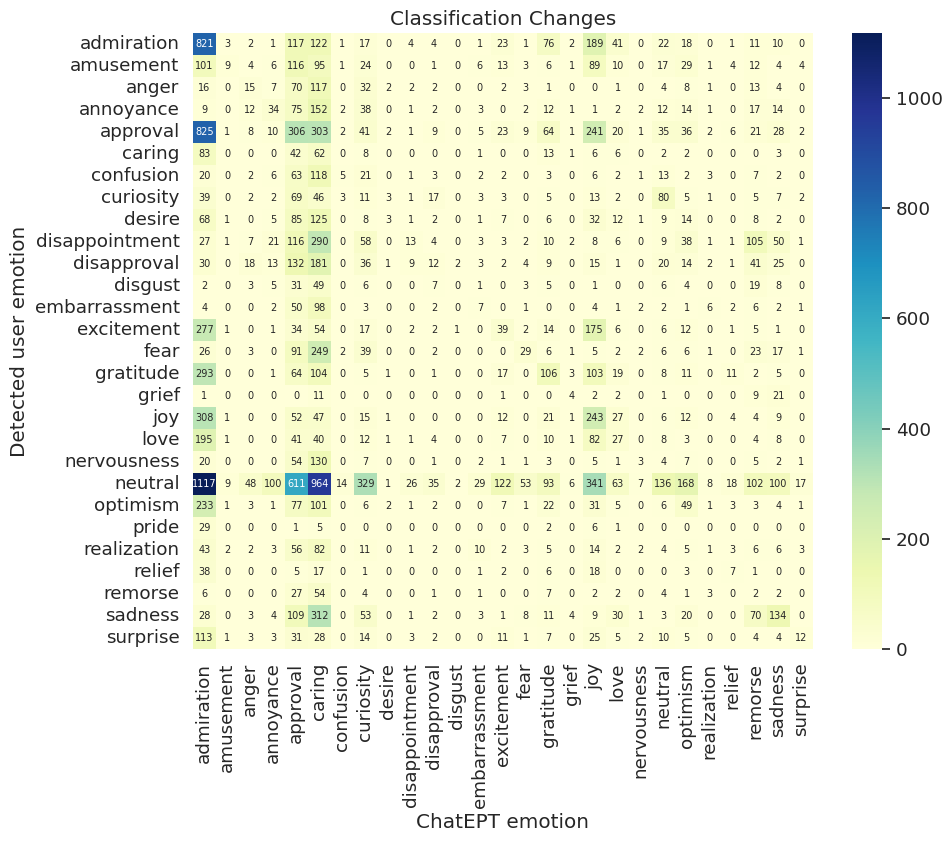

In [17]:
# Create two sample Series
s1 = chatept_output.utterance_minus_2_emotion
s2 = outputs_df.emotional_emotion

# Create a crosstab of the two Series
crosstab_emotional = pd.crosstab(s1, s2)

# Create a heatmap of the crosstab
plt.figure(figsize=(10,8))
sns.heatmap(crosstab_emotional, annot=True, cmap='YlGnBu', fmt='.0f', annot_kws={'fontsize':7})
plt.xlabel('ChatEPT emotion')
plt.ylabel('Detected user emotion')
plt.title('Classification Changes')
plt.show()

### ChatGPT vs ChatEPT response emotion choices

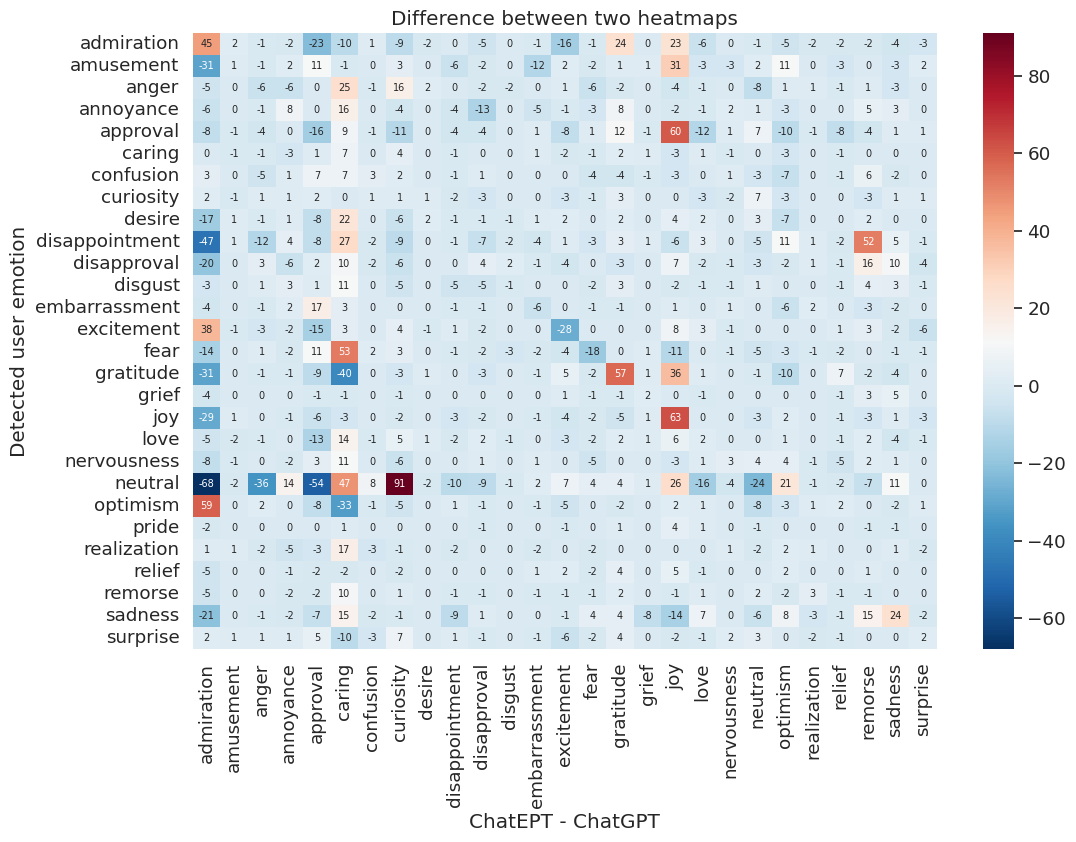

In [18]:
# Compute the difference between the two heatmaps
heatmap_diff = crosstab_emotional - crosstab_non_emotional

# Plot the difference heatmap
#plt.imshow(heatmap_diff, cmap='RdBu_r')
vmin = heatmap_diff.min().min()
vmax = heatmap_diff.max().max()
ticks = [vmax, (vmax + vmin) / 2, vmin]


sns.heatmap(heatmap_diff, annot=True, cmap='RdBu_r', fmt='.0f', annot_kws={'fontsize':7})
# Add a colorbar and title
#plt.colorbar()
plt.xlabel('ChatEPT - ChatGPT')
plt.ylabel('Detected user emotion')
plt.title('Difference between two heatmaps')

# Show the plot
plt.show()

In [19]:
utterance_2_support_per_emotion = []
for i in range(len(emotion_categories)):
    emotion_i = emotion_categories[i]
    utterance_2_emotion_i_df = chatept_output[chatept_output.utterance_minus_2_emotion == emotion_i]
    utterance_2_support_per_emotion.append(len(utterance_2_emotion_i_df))
support_dict = {k: v for k, v in zip(emotion_categories, utterance_2_support_per_emotion)}
adjusted_support_list = []
for emotion in crosstab_emotional.index.to_list():
    adjusted_support_list.append(support_dict[emotion])

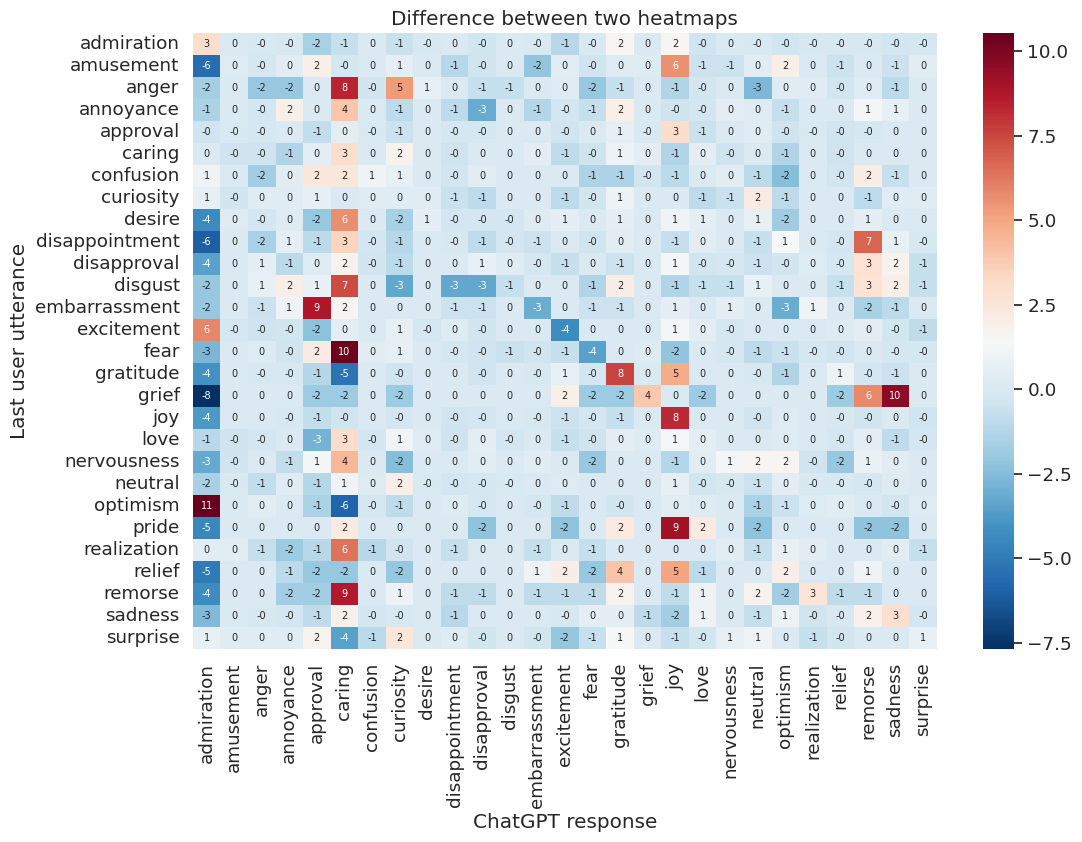

In [20]:
# Compute the difference between the two heatmaps
heatmap_diff = crosstab_emotional - crosstab_non_emotional
normalized_heatmap_diff = 100*heatmap_diff.div(adjusted_support_list, axis=0)

# Plot the difference heatmap
#plt.imshow(heatmap_diff, cmap='RdBu_r')
#vmin = heatmap_diff.min().min()
#vmax = heatmap_diff.max().max()
#ticks = [vmax, (vmax + vmin) / 2, vmin]


sns.heatmap(normalized_heatmap_diff, annot=True, cmap='RdBu_r', fmt='.0f', annot_kws={'fontsize':7})
# Add a colorbar and title
#plt.colorbar()
plt.xlabel('ChatGPT response')
plt.ylabel('Last user utterance')
plt.title('Difference between two heatmaps')

# Show the plot
plt.show()

## How did emotions move? A 3D heatmap 

IndexError: tuple index out of range

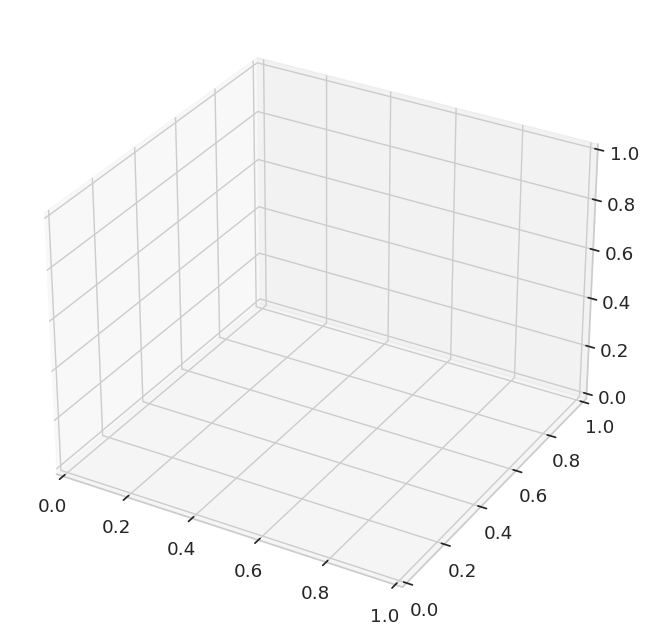

In [214]:
# Create two sample Series
s1 = outputs_df.non_emotional_emotion
s2 = outputs_df.emotional_emotion
s3 = outputs_df.utterance_minus_2_emotion

# Create a crosstab of the two Series
crosstab = pd.crosstab(index=s3, columns=[s1, s2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = np.meshgrid(range(crosstab.shape[1]), range(crosstab.shape[0]), range(crosstab.shape[2]))
ax.scatter(x.flatten(), y.flatten(), z.flatten(), c=crosstab.values.flatten(), cmap='coolwarm', marker='o')
ax.set_xlabel('Chatbot1 Emotion')
ax.set_ylabel('User Emotion')
ax.set_zlabel('Chatbot2 Emotion')
plt.show()

/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


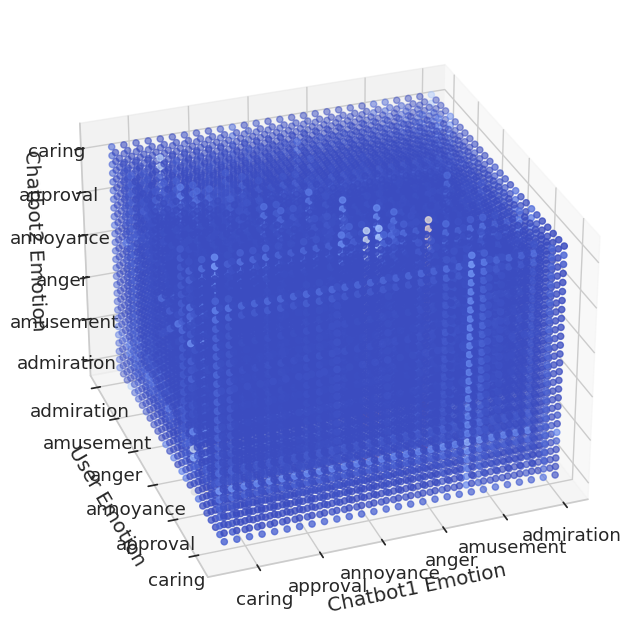

In [216]:
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

s0 = outputs_df.utterance_minus_2_emotion
s1 = outputs_df.non_emotional_emotion
s2 = outputs_df.emotional_emotion

# Create crosstabs for chatbot1 and chatbot2 emotions
crosstab1 = pd.crosstab(index=s0, columns=s1)
crosstab2 = pd.crosstab(index=s0, columns=s2)

# Create a 3D array from the crosstabs
crosstab3d = np.zeros((28, 27, 27))
for i, user_emotion in enumerate(crosstab1.index):
    for j, chatbot1_emotion in enumerate(crosstab1.columns):
        for k, chatbot2_emotion in enumerate(crosstab2.columns):
            value1 = crosstab1.loc[user_emotion, chatbot1_emotion]
            value2 = crosstab2.loc[user_emotion, chatbot2_emotion]
            crosstab3d[i, j, k] = (value1 + value2) / 2

# Create a 3D heatmap
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = np.meshgrid(range(28), range(27), range(27))
ax.scatter(x.flatten(), y.flatten(), z.flatten(), c=crosstab3d.flatten(), cmap='coolwarm', marker='o')
ax.set_xticklabels([''] + crosstab1.columns.tolist())
ax.set_yticklabels([''] + crosstab1.index.tolist())
ax.set_zticklabels([''] + crosstab2.columns.tolist())
ax.set_xlabel('Chatbot1 Emotion')
ax.set_ylabel('User Emotion')
ax.set_zlabel('Chatbot2 Emotion')

ax.view_init(elev=30, azim=70)

plt.show()


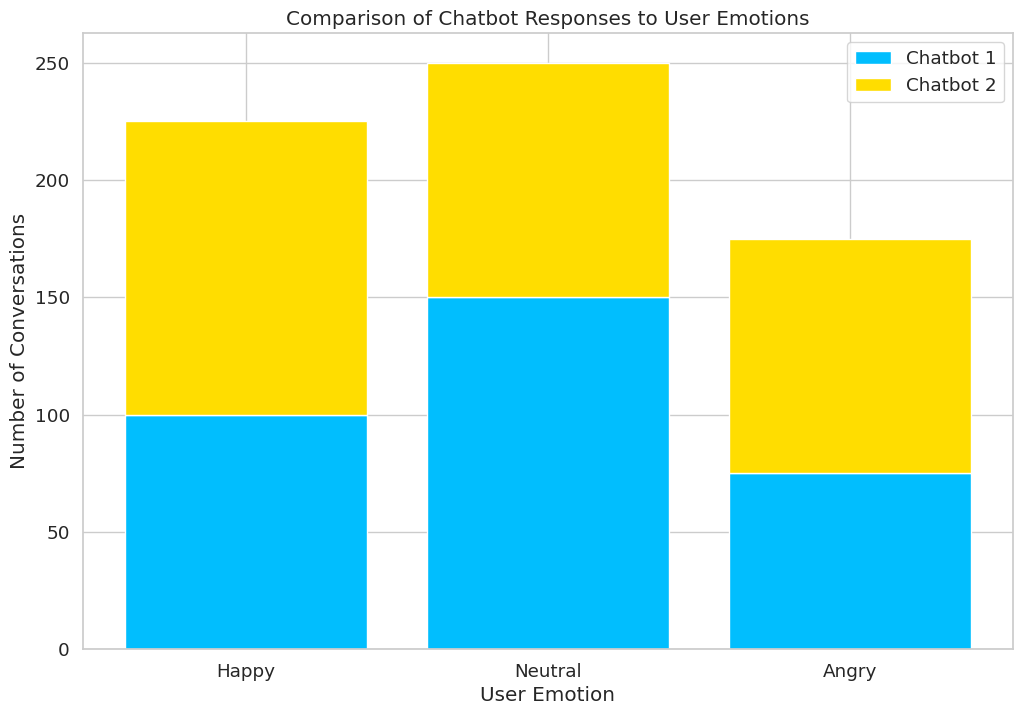

In [218]:
# create sample data
user_emotions = ["Happy", "Neutral", "Angry"]
chatbot1_emotions = [100, 150, 75]
chatbot2_emotions = [125, 100, 100]

# create stacked bar chart
fig, ax = plt.subplots()

s0 = outputs_df.utterance_minus_2_emotion
s1 = outputs_df.non_emotional_emotion
s2 = outputs_df.emotional_emotion

ax.bar(s0, s1, label="Chatbot 1")
ax.bar(user_emotions, chatbot2_emotions, bottom=chatbot1_emotions, label="Chatbot 2")

# set labels and title
ax.set_xlabel("User Emotion")
ax.set_ylabel("Number of Conversations")
ax.set_title("Comparison of Chatbot Responses to User Emotions")
ax.legend()

# display chart
plt.show()


In [225]:
data = chatept_output[["conv_id", "utterance_minus_2_emotion", "no_emotion_chatgpt_response_emotion", "emotional_chatgpt_response_emotion"]]
data[['non_emotional_emotion', 'non_emotional_conf']] = data['no_emotion_chatgpt_response_emotion'].apply(lambda x: pd.Series(x))
data[['emotional_emotion', 'emotional_conf']] = data['emotional_chatgpt_response_emotion'].apply(lambda x: pd.Series(x))
data.head()

/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


conv_id utterance_minus_2_emotion  \
0          hit:0_conv:1                   neutral   
1  hit:10000_conv:20000                       joy   
2  hit:10000_conv:20001                   neutral   
3  hit:10001_conv:20002            disappointment   
4  hit:10002_conv:20004             embarrassment   

  no_emotion_chatgpt_response_emotion emotional_chatgpt_response_emotion  \
0                      (grief, 55.02)                   (sadness, 97.31)   
1                 (admiration, 90.69)                (admiration, 85.92)   
2                 (admiration, 90.89)                      (love, 94.29)   
3                    (remorse, 82.51)                  (optimism, 70.82)   
4                     (caring, 94.53)                  (approval, 57.74)   

  non_emotional_emotion  non_emotional_conf emotional_emotion  emotional_conf  
0                 grief               55.02           sadness           97.31  
1            admiration               90.69        admiration           85.92  
2            admiration               90.89              love           94.29  
3               remorse               82.51          optimism           70.82  
4                caring               94.53          approval           57.74

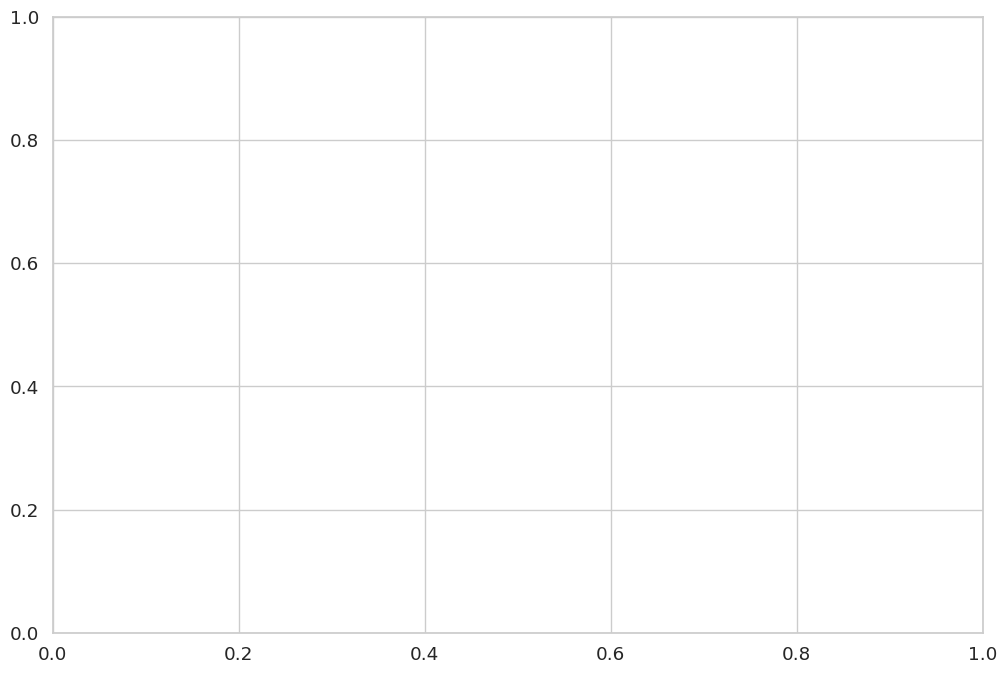

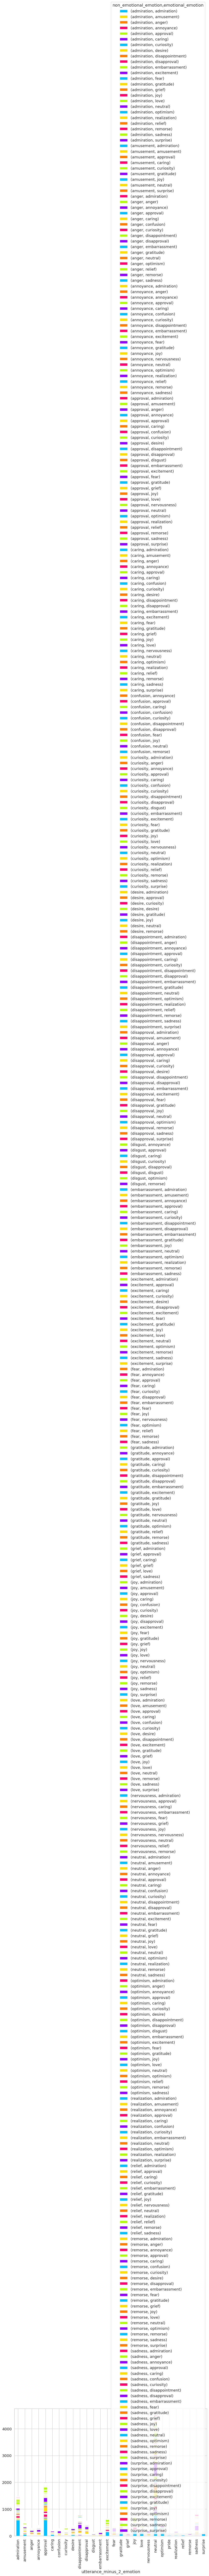

In [234]:
fig, ax = plt.subplots()

crosstab_data = pd.crosstab(data["utterance_minus_2_emotion"], [data["non_emotional_emotion"], data["emotional_emotion"]])

# create the stacked bar chart
ax = crosstab_data.plot(kind="bar", stacked=True)


In [233]:
grouped_data

non_emotional_emotion  \
utterance_minus_2_emotion                                      
admiration                admiration                   776.0   
                          amusement                      1.0   
                          anger                          3.0   
                          annoyance                      3.0   
                          approval                     140.0   
...                                                      ...   
surprise                  realization                    2.0   
                          relief                         1.0   
                          remorse                        4.0   
                          sadness                        4.0   
                          surprise                      10.0   

                                       emotional_emotion  
utterance_minus_2_emotion                                 
admiration                admiration               821.0  
                          amusement                  3.0  
                          anger                      2.0  
                          annoyance                  1.0  
                          approval                 117.0  
...                                                  ...  
surprise                  realization                0.0  
                          relief                     0.0  
                          remorse                    4.0  
                          sadness                    4.0  
                          surprise                  12.0  

[615 rows x 2 columns]

# Now we exclude conversations where ChatGPT is neutral

In [32]:
#chatept_output_no_neutral = chatept_output[chatept_output.no_emotion_chatgpt_response_emotion.apply(lambda x: x[0]) == "neutral"]
chatept_output_no_neutral = chatept_output[chatept_output.no_emotion_chatgpt_response_emotion.apply(lambda x: x[1]) < 50]
print(f"Out of the {len(chatept_output)} total conversations, there are {len(chatept_output_no_neutral)} where the ChatGPT is neutral and {len(chatept_output) - len(chatept_output_no_neutral)} in which ChatGPT responds with emotions")
chatept_output_no_neutral.head()

Out of the 17780 total conversations, there are 1533 where the ChatGPT is neutral and 16247 in which ChatGPT responds with emotions


index               conv_id    context  \
28     28    hit:1002_conv:2004  surprised   
49     49  hit:10070_conv:20140    furious   
52     52  hit:10075_conv:20150    hopeful   
68     68  hit:10093_conv:20187   prepared   
72     72    hit:1009_conv:2018    ashamed   

                                            utterance  \
28  [My husband hasn't planned a date for the two ...   
49  [Oh boy I am livid! I just got this new couch ...   
52  [It's been a rough day! My water heater is bus...   
68  [I just dyed my hair for the first time by mys...   
72  [My best friend for years and I got into a fig...   

   utterance_minus_2_emotion  utterance_minus_2_emotion_conf  \
28                  approval                           26.16   
49                admiration                           68.82   
52                  optimism                           97.90   
68                admiration                           68.34   
72                   disgust                           55.00   

                          chatgpt_response_no_emotion  \
28  Absolutely, it's important to make time for ea...   
49  I'm sorry to hear that. Consider covering your...   
52  That's great news! I hope everything works out...   
68  That's a good tip! It's always helpful to watc...   
72  It's understandable that you're feeling awful ...   

                           chatgpt_emotional_response  \
28  (approval, 26.16, Yes, life can be unpredictab...   
49  (admiration, 68.82, I understand how frustrati...   
52  (optimism, 97.9, That's great! Hope your weeke...   
68  (admiration, 68.34, That's a great tip! I'm gl...   
72  (disgust, 55.0, I'm sorry to hear that. Have y...   

   no_emotion_chatgpt_response_emotion emotional_chatgpt_response_emotion  
28                   (approval, 37.12)                   (approval, 49.4)  
49                    (remorse, 45.16)                    (caring, 94.65)  
52                        (joy, 34.24)                (admiration, 85.03)  
68                  (gratitude, 49.74)                (admiration, 87.73)  
72                     (caring, 48.25)                 (gratitude, 73.77)

In [28]:
chatept_output.no_emotion_chatgpt_response_emotion.apply(lambda x: x[0]).value_counts()

admiration        4955
caring            3748
approval          2640
joy               1441
curiosity          750
optimism           488
neutral            473
sadness            434
remorse            419
gratitude          405
excitement         366
love               321
annoyance          223
anger              203
fear               178
disapproval        175
disappointment     119
embarrassment      113
relief              87
surprise            62
realization         33
amusement           32
confusion           31
grief               28
nervousness         27
desire              15
disgust             14
Name: no_emotion_chatgpt_response_emotion, dtype: int64

# Now we exclude conversations with neutral user

In [21]:
chatept_output_no_neutral = chatept_output[chatept_output.utterance_minus_2_emotion != "neutral"]
print(f"Out of the {len(chatept_output)} total conversations, there are {len(chatept_output_no_neutral)} where the user is neutral and {len(chatept_output) - len(chatept_output_no_neutral)} in which the user is feeling emotions")
chatept_output_no_neutral.head()

Out of the 17780 total conversations, there are 13261 where the user is neutral and 4519 in which the user is feeling emotions


index               conv_id    context  \
1      1  hit:10000_conv:20000  surprised   
3      3  hit:10001_conv:20002     lonely   
4      4  hit:10002_conv:20004    ashamed   
5      5  hit:10002_conv:20005     guilty   
7      7  hit:10004_conv:20008  surprised   

                                           utterance  \
1  [My girlfriend got me a pet toad today!, Do yo...   
3  [I went to the skating rink all by myself toda...   
4  [I was walking on the road. I saw a beggar and...   
5  [I ate my co-worker's cake_comma_ which was in...   
7  [My little cousin gifted me for my birthday, V...   

  utterance_minus_2_emotion  utterance_minus_2_emotion_conf  \
1                       joy                           98.35   
3            disappointment                           31.49   
4             embarrassment                           99.49   
5               realization                           67.58   
7                  approval                           46.41   

                         chatgpt_response_no_emotion  \
1  That's great to hear! Toads can make wonderful...   
3  I'm sorry to hear that. It's tough to feel lef...   
4  It's never too late to help someone in need. N...   
5  It's understandable that you were hungry, but ...   
7  That's so thoughtful and hardworking of him. I...   

                          chatgpt_emotional_response  \
1  (joy, 98.35, That's great to hear! Toads can m...   
3  (disappointment, 31.49, I'm sorry to hear that...   
4  (embarrassment, 99.49, That's completely under...   
5  (realization, 67.58, You should apologize and ...   
7  (approval, 46.41, That's wonderful to hear! It...   

  no_emotion_chatgpt_response_emotion emotional_chatgpt_response_emotion  
1                 (admiration, 90.69)                (admiration, 85.92)  
3                    (remorse, 82.51)                  (optimism, 70.82)  
4                     (caring, 94.53)                  (approval, 57.74)  
5                   (approval, 96.22)                  (approval, 93.43)  
7                 (admiration, 99.62)                       (joy, 95.16)